In [1]:
import pandas as pd
import numpy as np
from decimal import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
ukb = pd.read_csv('data/ukb_2023-03-14.csv', index_col=0)

                     # Baseline 
ukb_clean = ukb[['RIDRETH', 'RIDAGEYR', "RIAGENDR",
                     # Anthropometric
                     'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
                     'BMXSIT'
                ]].dropna()

ukb_clean = ukb_clean.reset_index(drop=True)

In [3]:
def bootstrap(X_train, y_train, n_bootstraps):

    # Initialize array to store bootstrap coefficients
    models = []

    # Perform bootstrap resampling and Lasso regression on training data
    for i in range(n_bootstraps):
        # Generate bootstrap sample
        indices = np.random.choice(X_train.index, size=X_train.shape[0], replace=True)
        X_boot = X_train.loc[indices]
        y_boot = y_train[indices]
        model = Ridge(alpha=0.01)
        model.fit(X_boot, y_boot)
        models.append(model)
        
    return models

# Predicting Sitting Height (Race Included)

## Train and Test on UKB

In [4]:
X = ukb_clean.drop(['BMXSIT'], axis = 1)
y = ukb_clean['BMXSIT']
 
categorical_columns = ['RIDRETH']
for column in categorical_columns:
    one_hot = pd.get_dummies(X[column], prefix=column)
    X = X.drop(column, axis=1)
    X = X.join(one_hot)

X['RIDRETH_Hispanic'] = 0
categorical_columns = list(ukb_clean.select_dtypes(include=['object']).columns)
numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']

X = X.applymap(lambda x: 1 if x == True else x)
X = X.applymap(lambda x: 0 if x == False else x)

X_num = X[numerical_columns]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_num))
X_scaled.columns = X_num.columns

X = X.drop(numerical_columns, axis=1)
X = X.reset_index(drop=True)

X_new = pd.concat([X_scaled, X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    stratify=X_new.join(ukb_clean['RIDRETH'])['RIDRETH'],
                                                    test_size=0.2, random_state=42)
    

In [5]:
models = bootstrap(X_train, y_train, n_bootstraps=50)
maes = []
mse = []
r2s = []
for m in models:  
    y_pred = m.predict(X_test)
    # Calculate the MAE and CI for all people
    mae_all = mean_absolute_error(y_test, y_pred)
    mse_all = mean_squared_error(y_test, y_pred)
    r2_all = r2_score(y_test, y_pred)
    maes.append(mae_all)
    mse.append(mse_all)
    r2s.append(r2_all)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

model = Ridge()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Train the model with the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
mean_score = -grid_search.best_score_

y_pred = model.predict(X_test)

# Calculate the MAE and CI for all people
mae_all = mean_absolute_error(y_test, y_pred)
mse_all = mean_squared_error(y_test, y_pred)
r2_all = r2_score(y_test, y_pred)

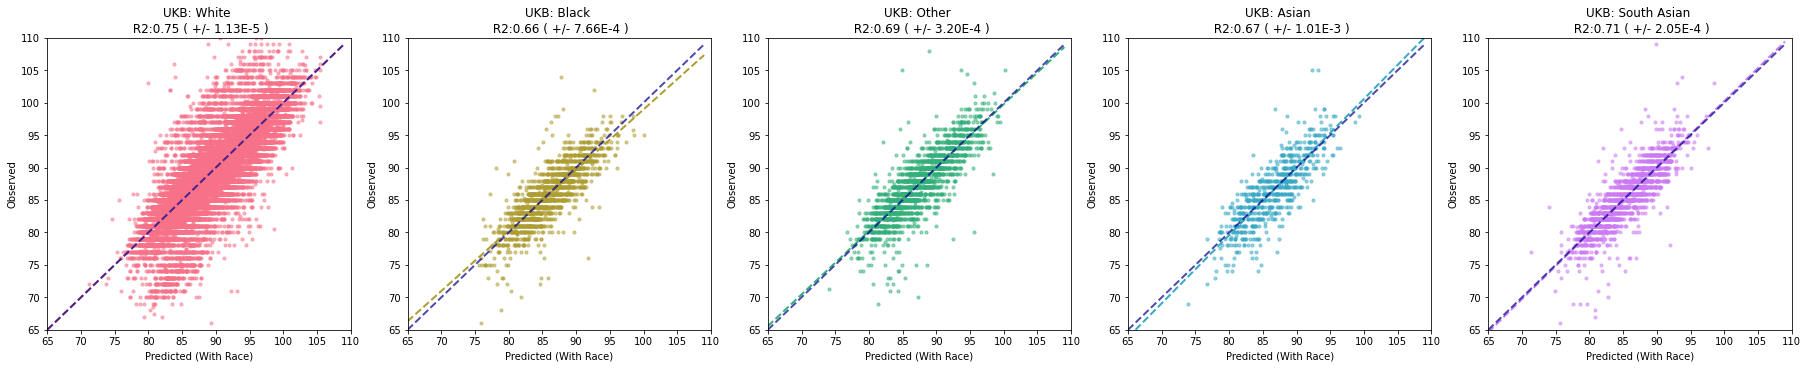

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
# Set color palette
palette = sns.color_palette("husl", len(ukb_clean['RIDRETH'].unique()))

race_columns = X_test[['RIDRETH_White', 'RIDRETH_Black', 'RIDRETH_Other',
       'RIDRETH_Asian', 'RIDRETH_South Asian']].columns
for i, r in enumerate(race_columns):
    
    maes = []
    mse = []
    r2s = []
    for m in models:  
        y_test_race = y_test[X_test[X_test[r]==1].index]
        y_pred = m.predict(X_test[X_test[r]==1])
        mae_race = mean_absolute_error(y_test_race, y_pred)
        mse_race = mean_squared_error(y_test_race, y_pred)
        r2_race = r2_score(y_test_race, y_pred)
        maes.append(mae_race)
        mse.append(mse_race)
        r2s.append(r2_race)
    
    z_score = 1.96  # 95% confidence interval
    ci_mae = z_score*np.std(maes, ddof=1)
    ci_mse = z_score*np.std(mse, ddof=1)
    ci_r2s = z_score*np.std(r2s, ddof=1)
        
    y_test_race = y_test[X_test[X_test[r]==1].index]
    y_pred = model.predict(X_test[X_test[r]==1])

    mae_black = mean_absolute_error(y_test_race, y_pred)
    mse_black = mean_squared_error(y_test_race, y_pred)
    r2_race = r2_score(y_test_race, y_pred)

    # Calculate regression line
    reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test_race)
    line_x = np.arange(65, 110).reshape(-1, 1)
    line_y = reg.predict(line_x)
    
    reg = LinearRegression().fit(y_test_race.values.reshape(-1,1) , y_test_race)
    perf_line_x = np.arange(65, 110).reshape(-1, 1)
    perf_line_y = reg.predict(line_x)
    
    # Create scatterplot and plot line of best fit
    axs[i].scatter(y_pred, y_test_race, alpha = 0.5, s = 10, color = palette[i])
    axs[i].plot(line_x, line_y, linestyle='--', linewidth=2, color = palette[i])
    axs[i].plot(perf_line_x, perf_line_x, linestyle='--', label='R2: 1', linewidth=2, alpha=0.7, color = 'darkblue')

    race_title = r.split('_')[1]
    axs[i].set_title(f'UKB: {race_title} \n R2:{round(r2_race,2)} ( +/- {Decimal(ci_r2s):.2E} )')
    axs[i].set_xlim(65, 110)
    axs[i].set_ylim(65, 110)
    
    # Add title, axis labels, and legend to plot
    axs[i].set_xlabel('Predicted (With Race)', fontsize = 10)
    axs[i].set_ylabel('Observed', fontsize = 10)


## Test on all of NHANES III (Race-Included)


In [7]:
nhanes3 = pd.read_csv('data/nhanes3_adult_2023-04-02.csv')

# rename the columns
nhanes3_clean = nhanes3.rename(columns={
    'BMXSITHT': 'BMXSIT',
    'IS_FEMALE': 'RIAGENDR', 
})

keep_cols = ['RIAGENDR', 'RIDAGEYR', 
         'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
         'BMXSIT' , 'RIDRETH'
            ]

nhanes3_clean = nhanes3_clean[keep_cols].dropna()
nhanes3_clean = nhanes3_clean.reset_index(drop = True)
nhanes3_clean['RIAGENDR'] = nhanes3_clean['RIAGENDR'].astype(int)
    
nhanes3_clean = nhanes3_clean[nhanes3_clean['RIDRETH'].isin(['White', 'Hispanic', 'Black', 'Other'])]
nhanes3_clean['RIDRETH_Asian'] = 0
nhanes3_clean['RIDRETH_South Asian'] = 0 

X_nhanes = nhanes3_clean.drop(['BMXSIT'], axis = 1)
y_nhanes = nhanes3_clean['BMXSIT']
    
categorical_columns = ['RIDRETH']
for column in categorical_columns:
    one_hot = pd.get_dummies(X_nhanes[column], prefix=column)
    X_nhanes = X_nhanes.drop(column, axis=1)
    X_nhanes = X_nhanes.join(one_hot)


numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']


X_num = X_nhanes[numerical_columns]
X_scaled = pd.DataFrame(scaler.fit_transform(X_num))
X_scaled.columns = X_num.columns

X = X_nhanes.drop(numerical_columns, axis=1)

X_new = pd.concat([X_scaled, X], axis=1)[X_train.columns]



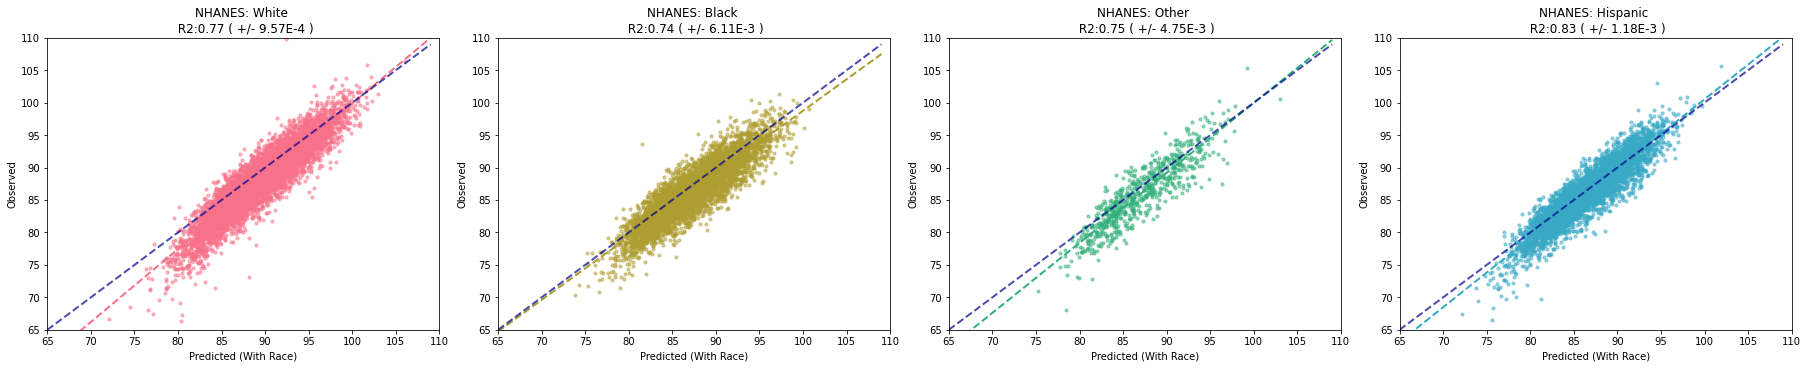

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5), constrained_layout=True)
# Set color palette
palette = sns.color_palette("husl", len(ukb_clean['RIDRETH'].unique()))

race_columns = [ 'RIDRETH_White', 'RIDRETH_Black',
       'RIDRETH_Other','RIDRETH_Hispanic']
for i, r in enumerate(race_columns):
    maes = []
    mse = []
    r2s = []
    for m in models:  
        y_test_race = y_nhanes[X_new[X_new[r]==1].index]
        y_pred = m.predict(X_new[X_new[r]==1])
        mae_race = mean_absolute_error(y_test_race, y_pred)
        mse_race = mean_squared_error(y_test_race, y_pred)
        r2_race = r2_score(y_test_race, y_pred)
        maes.append(mae_race)
        mse.append(mse_race)
        r2s.append(r2_race)
    
    z_score = 1.96  # 95% confidence interval
    ci_mae = z_score*np.std(maes, ddof=1)
    ci_mse = z_score*np.std(mse, ddof=1)
    ci_r2s = z_score*np.std(r2s, ddof=1)
    
    
    y_test_race = y_nhanes[X_new[X_new[r]==1].index]
    y_pred = model.predict(X_new[X_new[r]==1])

    mae_black = mean_absolute_error(y_test_race, y_pred)
    mse_black = mean_squared_error(y_test_race, y_pred)
    r2_race = r2_score(y_test_race, y_pred)
    
    # Calculate regression line
    reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test_race)
    line_x = np.arange(65, 110).reshape(-1, 1)
    line_y = reg.predict(line_x)
    
    reg = LinearRegression().fit(y_test_race.values.reshape(-1,1) , y_test_race)
    perf_line_x = np.arange(65, 110).reshape(-1, 1)
    perf_line_y = reg.predict(line_x)

    # Create scatterplot and plot line of best fit
    axs[i].scatter(y_pred, y_test_race, alpha = 0.5, s = 10, color = palette[i])
    axs[i].plot(line_x, line_y, linestyle='--', linewidth=2, color = palette[i])
    axs[i].plot(perf_line_x, perf_line_x, linestyle='--', label='R2: 1', linewidth=2, alpha=0.7, color = 'darkblue')

    race_title = r.split('_')[1]
    axs[i].set_title(f'NHANES: {race_title} \n R2:{round(r2_race,2)}')
    axs[i].set_title(f'NHANES: {race_title} \n R2:{round(r2_race,2)} ( +/- {Decimal(ci_r2s):.2E} )')

    axs[i].set_xlim(65, 110)
    axs[i].set_ylim(65, 110)
    
    # Add title, axis labels, and legend to plot
    axs[i].set_xlabel('Predicted (With Race)', fontsize = 10)
    axs[i].set_ylabel('Observed', fontsize = 10)
    


# Predicting Sitting Height (Without Race)

## Train and Test on UKB

In [9]:
X = ukb_clean.drop(['BMXSIT', 'RIDRETH'], axis = 1)
y = ukb_clean['BMXSIT']

categorical_columns = list(ukb_clean.select_dtypes(include=['object']).columns)
numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']

X = X.applymap(lambda x: 1 if x == True else x)
X = X.applymap(lambda x: 0 if x == False else x)

X_num = X[numerical_columns]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_num))
X_scaled.columns = X_num.columns

X = X.drop(numerical_columns, axis=1)
X = X.reset_index(drop=True)

X_new = pd.concat([X_scaled, X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                        stratify=X_new.join(ukb_clean['RIDRETH'])['RIDRETH'],
                                                        test_size=0.2, random_state=42)
    

In [10]:
models = bootstrap(X_train, y_train, n_bootstraps=50)
maes = []
mse = []
r2s = []
for m in models:  
    y_pred = m.predict(X_test)
    # Calculate the MAE and CI for all people
    mae_all = mean_absolute_error(y_test, y_pred)
    mse_all = mean_squared_error(y_test, y_pred)
    r2_all = r2_score(y_test, y_pred)
    maes.append(mae_all)
    mse.append(mse_all)
    r2s.append(r2_all)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

model = Ridge()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Train the model with the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
mean_score = -grid_search.best_score_

y_pred = model.predict(X_test)

# Calculate the MAE and CI for all people
mae_all = mean_absolute_error(y_test, y_pred)
mse_all = mean_squared_error(y_test, y_pred)
r2_all = r2_score(y_test, y_pred)

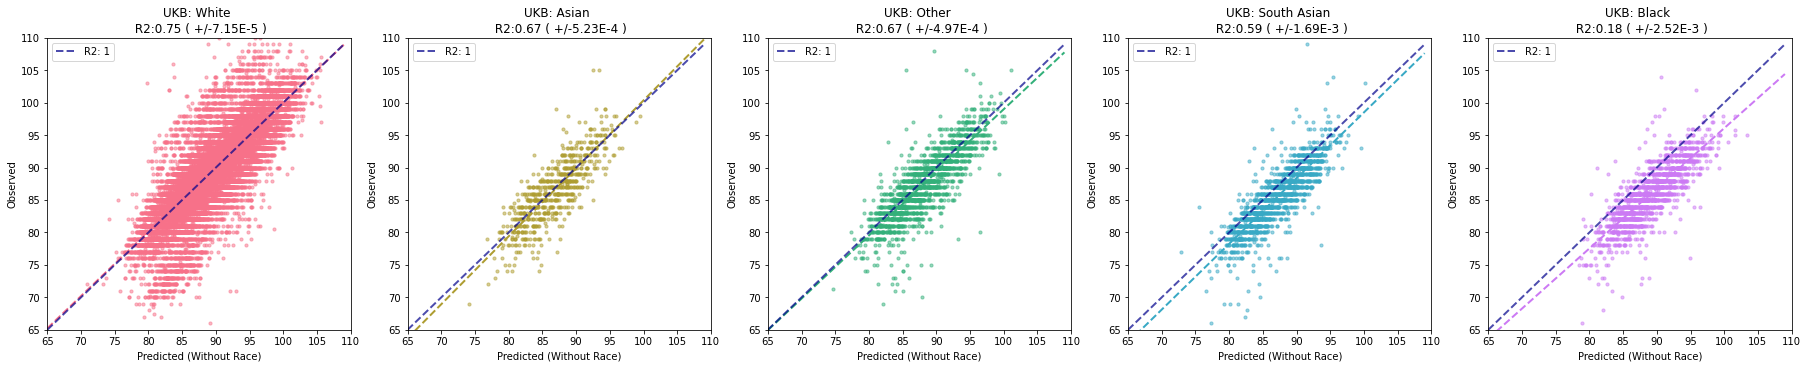

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
# Set color palette
palette = sns.color_palette("husl", len(ukb_clean['RIDRETH'].unique()))

X_test.join(ukb_clean['RIDRETH'])
X_test_race = X_test.join(ukb_clean['RIDRETH'])
for j, i in enumerate(X_test_race.RIDRETH.unique()):
    X_test_i = X_test_race[X_test_race['RIDRETH'] == i].drop('RIDRETH', axis=1)
    y_test_i = y_test[X_test_i.index]
    
    maes = []
    mse = []
    r2s = []
    for m in models:  
        y_pred = m.predict(X_test_i[X_train.columns])
        mae_race = mean_absolute_error(y_test_i, y_pred)
        mse_race = mean_squared_error(y_test_i, y_pred)
        r2_race = r2_score(y_test_i, y_pred)
        maes.append(mae_race)
        mse.append(mse_race)
        r2s.append(r2_race)
        
    z_score = 1.96  # 95% confidence interval
    ci_mae = z_score*np.std(maes, ddof=1)
    ci_mse = z_score*np.std(mse, ddof=1)
    ci_r2s = z_score*np.std(r2s, ddof=1)
        
    y_pred = model.predict(X_test_i[X_train.columns])

    mae_black = mean_absolute_error(y_test_i, y_pred)
    mse_black = mean_squared_error(y_test_i, y_pred)
    r2_race = r2_score(y_test_i, y_pred)

    # Calculate regression line
    
    reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test_i)
    line_x = np.arange(65, 110).reshape(-1, 1)
    line_y = reg.predict(line_x)
    
    reg = LinearRegression().fit(y_test_i.values.reshape(-1,1) , y_test_i)
    perf_line_x = np.arange(65, 110).reshape(-1, 1)
    perf_line_y = reg.predict(line_x)

    # Create scatterplot and plot line of best fit
    axs[j].scatter(y_pred, y_test_i, alpha = 0.5, s = 10, color = palette[j])
    axs[j].plot(line_x, line_y, linestyle='--', linewidth=2, color = palette[j])
    axs[j].plot(perf_line_x, perf_line_x, linestyle='--', label='R2: 1', linewidth=2, alpha=0.7, color = 'darkblue')
    axs[j].legend()
    
    race_title = i
    axs[j].set_title(f'UKB: {race_title} \n R2:{round(r2_race,2)} ( +/-{Decimal(ci_r2s):.2E} )')
    axs[j].set_xlim(65, 110)
    axs[j].set_ylim(65, 110)
    
    # Add title, axis labels, and legend to plot
    axs[j].set_xlabel('Predicted (Without Race)', fontsize = 10)
    axs[j].set_ylabel('Observed', fontsize = 10)


## Test on all of NHANES III (Race-Included)

In [12]:
nhanes3 = pd.read_csv('data/nhanes3_adult_2023-04-02.csv')

# rename the columns
nhanes3_clean = nhanes3.rename(columns={
    'BMXSITHT': 'BMXSIT',
    'IS_FEMALE': 'RIAGENDR', 
})

keep_cols = ['RIAGENDR', 'RIDAGEYR', 
         'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
         'BMXSIT' , 'RIDRETH'
            ]

nhanes3_clean = nhanes3_clean[keep_cols].dropna()
nhanes3_clean = nhanes3_clean.reset_index(drop = True)
nhanes3_clean['RIAGENDR'] = nhanes3_clean['RIAGENDR'].astype(int)
    
nhanes3_clean = nhanes3_clean[nhanes3_clean['RIDRETH'].isin(['White', 'Hispanic', 'Black', 'Other'])]

X = nhanes3_clean.drop(['BMXSIT'], axis = 1)
y = nhanes3_clean['BMXSIT']
    
categorical_columns = ['RIDRETH']
for column in categorical_columns:
    one_hot = pd.get_dummies(X[column], prefix=column)
    X = X.drop(column, axis=1)
    X = X.join(one_hot)

categorical_columns = list(nhanes3_clean.select_dtypes(include=['object']).columns)
numerical_columns = ['RIDAGEYR', 'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST']

X = X.applymap(lambda x: 1 if x == True else x)
X = X.applymap(lambda x: 0 if x == False else x)

X_num = X[numerical_columns]
X_scaled = pd.DataFrame(scaler.fit_transform(X_num))
X_scaled.columns = X_num.columns

X = X.drop(numerical_columns, axis=1)

X_new = pd.concat([X_scaled, X], axis=1)[X_train.columns]

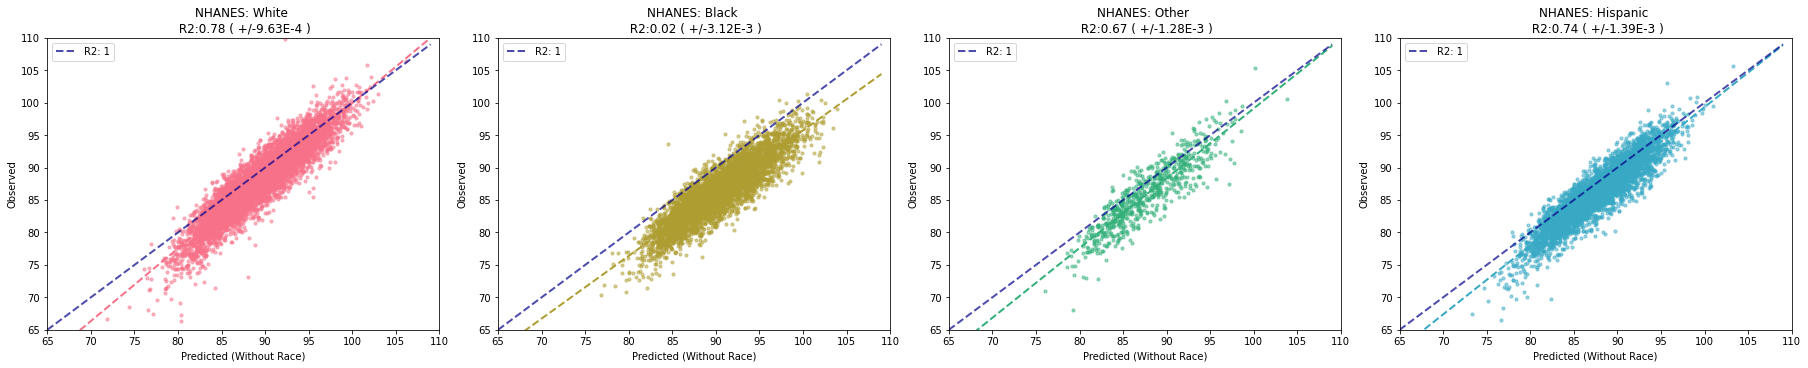

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5), constrained_layout=True)
# Set color palette
palette = sns.color_palette("husl", len(ukb_clean['RIDRETH'].unique()))

X_test_race = X_new.join(nhanes3_clean['RIDRETH'])
races = ['White', 'Black',  'Other', 'Hispanic',]
for j, i in enumerate(races):
    X_test_i = X_test_race[X_test_race['RIDRETH'] == i].drop('RIDRETH', axis=1)
    y_test_i = y[X_test_i.index]
    
    maes = []
    mse = []
    r2s = []
    for m in models:  
        y_pred = m.predict(X_test_i[X_train.columns])
        mae_race = mean_absolute_error(y_test_i, y_pred)
        mse_race = mean_squared_error(y_test_i, y_pred)
        r2_race = r2_score(y_test_i, y_pred)
        maes.append(mae_race)
        mse.append(mse_race)
        r2s.append(r2_race)
        
    z_score = 1.96  # 95% confidence interval
    ci_mae = z_score*np.std(maes, ddof=1)
    ci_mse = z_score*np.std(mse, ddof=1)
    ci_r2s = z_score*np.std(r2s, ddof=1)
        
    y_pred = model.predict(X_test_i[X_train.columns])

    mae_black = mean_absolute_error(y_test_i, y_pred)
    mse_black = mean_squared_error(y_test_i, y_pred)
    r2_race = r2_score(y_test_i, y_pred)

    # Calculate regression line
    
    reg = LinearRegression().fit(y_pred.reshape(-1, 1), y_test_i)
    line_x = np.arange(65, 110).reshape(-1, 1)
    line_y = reg.predict(line_x)
    
    reg = LinearRegression().fit(y_test_i.values.reshape(-1,1) , y_test_i)
    perf_line_x = np.arange(65, 110).reshape(-1, 1)
    perf_line_y = reg.predict(line_x)

    # Create scatterplot and plot line of best fit
    axs[j].scatter(y_pred, y_test_i, alpha = 0.5, s = 10, color = palette[j])
    axs[j].plot(line_x, line_y, linestyle='--', linewidth=2, color = palette[j])
    axs[j].plot(perf_line_x, perf_line_x, linestyle='--', label='R2: 1', linewidth=2, alpha=0.7, color = 'darkblue')
    axs[j].legend()
    
    race_title = i
    axs[j].set_title(f'NHANES: {race_title} \n R2:{round(r2_race,2)} ( +/-{Decimal(ci_r2s):.2E} )')
    axs[j].set_xlim(65, 110)
    axs[j].set_ylim(65, 110)
    
    # Add title, axis labels, and legend to plot
    axs[j].set_xlabel('Predicted (Without Race)', fontsize = 10)
    axs[j].set_ylabel('Observed', fontsize = 10)
